In [1]:
import torch
from torch.utils.data import DataLoader
from datasets import Dataset
import random
import copy
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

from sklearn.metrics import classification_report
from transformers import get_linear_schedule_with_warmup

import pyvene as pv
from pyvene import CausalModel
from pyvene.models.mlp.modelings_mlp import MLPConfig
from pyvene import create_mlp_classifier
from pyvene import (
    IntervenableModel,
    VanillaIntervention,
    RotatedSpaceIntervention,
    LowRankRotatedSpaceIntervention,
    RepresentationConfig,
    IntervenableConfig,
)


from model_analyzer import ModelAnalyzer
from activation_extraction import (
    ActivationRecord,
    save_activations,
    load_activations,
    compare_activations,
    get_activation_statistics
)
from intervention import (
    InterventionHandler,
    ActivationPatch,
    SteeringVector,
    create_steering_vector as _create_steering_vector
)

nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


In [2]:
# Multiplication version -- I will come back to this after I fix the pyvene bugs
# -- bug is regarding parent dependencies -- iterating through all combinations of parent values
# -- is incorrect because some parent combinations are impossible given their predecessors
#variables = ["X1X0", "Y1Y0", "X1X0*Y0", "X1X0*Y1*10", "Output"]
#reps_start = [i for i in range(10, 20)]
#reps_intermediate_1 = [i*j for i in range(10, 20) for j in range(0, 10)]
#reps_intermediate_2 = [i*j for i in range(10, 20) for j in (10, )]
#reps_final = [i*j for i in range(10, 20) for j in range(10, 20)]  # This is 100 to 361
#values = {variable: reps_start for variable in ["X1X0", "Y1Y0"]}
#values["X1X0*Y0"] = reps_intermediate_1
#values["X1X0*Y1*10"] = reps_intermediate_2
#values |= {variable: reps_final for variable in ["Output"]}

#for value in values:
    #print(value)
    #print(values[value])

#parents = {
    #"X1X0": [],
    #"Y1Y0": [],
    #"X1X0*Y0": ["X1X0", "Y1Y0"],
    #"X1X0*Y1*10": ["X1X0", "Y1Y0"],
    #"Output": ["X1X0*Y0", "X1X0*Y1*10"]
#}

#functions = {
    #"X1X0": lambda: random.randint(10, 19),
    #"Y1Y0": lambda: random.randint(10, 19),
    #"X1X0*Y0": lambda x, y: x * (y % 10),
    #"X1X0*Y1*10": lambda x, y: x * (y // 10) * 10,
    #"Output": lambda a, b: a + b,
#}

# Addition version
variables = ["X1X0", "Y1Y0", "X0+Y0", "(X1+Y1)*10", "Output"]
reps_start = [i for i in range(10, 20)]
reps_intermediate_1 = [i for i in range(0, 19)]
reps_intermediate_2 = [i + j for i in (10, ) for j in (10, )]
reps_final = [i for i in range(20, 39)]
values = {variable: reps_start for variable in ["X1X0", "Y1Y0"]}
values["X0+Y0"] = reps_intermediate_1
values["(X1+Y1)*10"] = reps_intermediate_2
values |= {variable: reps_final for variable in ["Output"]}

for value in values:
    print(value)
    print(values[value])

parents = {
    "X1X0": [],
    "Y1Y0": [],
    "X0+Y0": ["X1X0", "Y1Y0"],
    "(X1+Y1)*10": ["X1X0", "Y1Y0"],
    "Output": ["X0+Y0", "(X1+Y1)*10"]
}

functions = {
    "X1X0": lambda: random.randint(10, 19),
    "Y1Y0": lambda: random.randint(10, 19),
    "X0+Y0": lambda x, y: (x % 10) + (y % 10),
    "(X1+Y1)*10": lambda x, y: ((x // 10) + (y // 10)) * 10,
    "Output": lambda a, b: a + b,
}

pos = {
    "X1X0": (0, 0.4),
    "Y1Y0": (0, 0.6),
    "X0+Y0": (2, 0.4),
    "(X1+Y1)*10": (2, 0.6),
    "Output": (4, 0.5)
}

causal_model = CausalModel(
    variables=variables,
    parents=parents,
    functions=functions,
    values=values,
    pos=pos
)


X1X0
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Y1Y0
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
X0+Y0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
(X1+Y1)*10
[20]
Output
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


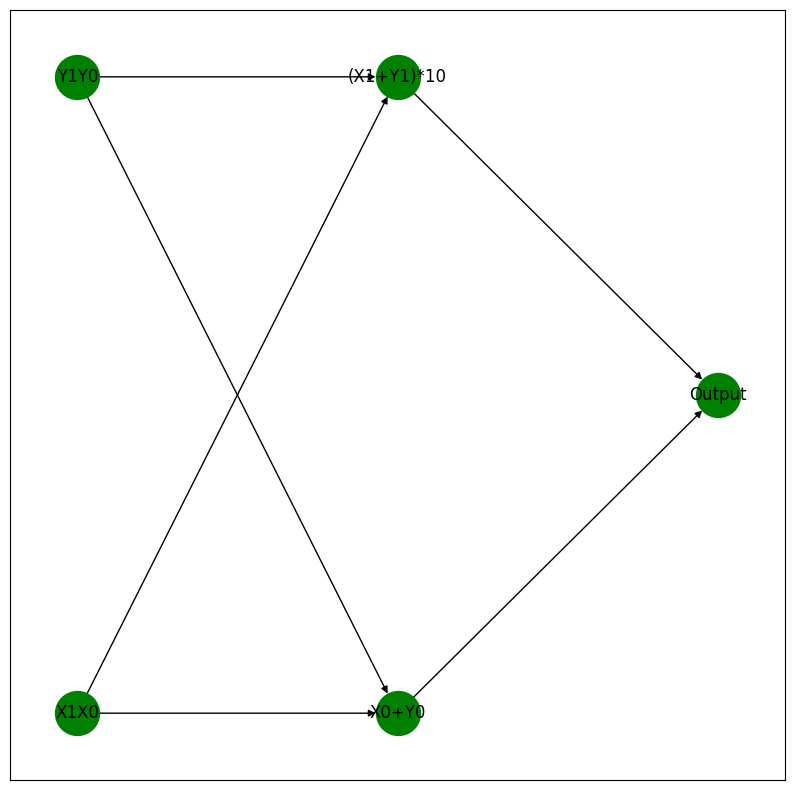

Timesteps: {'X1X0': 0, 'Y1Y0': 0, '(X1+Y1)*10': 1, 'X0+Y0': 1, 'Output': 2}


In [3]:
causal_model.print_structure()
print("Timesteps:", causal_model.timesteps)

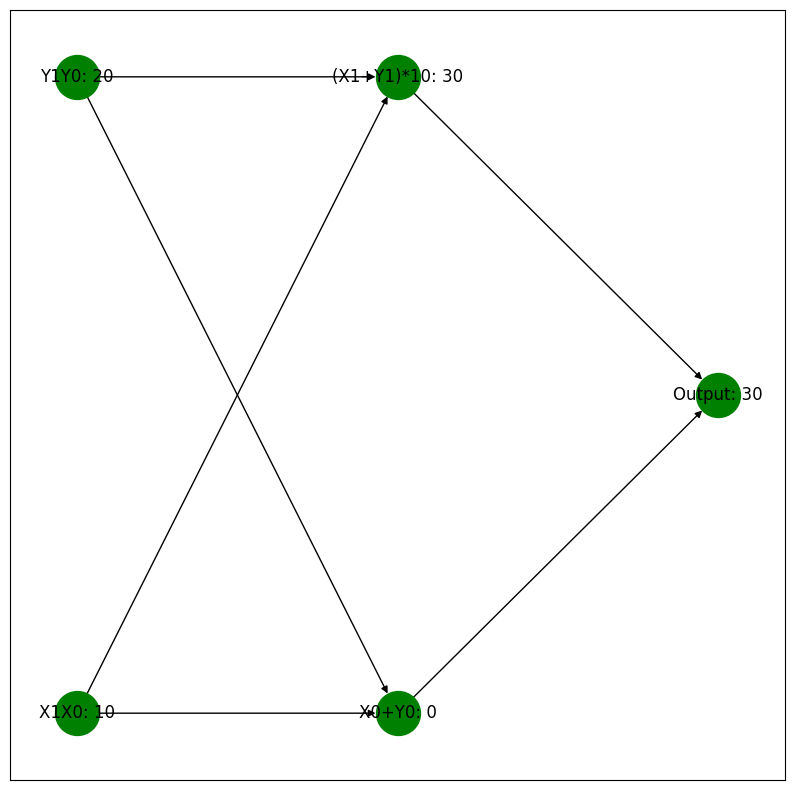

In [4]:
setting = causal_model.run_forward(
    {
        "X1X0": 10,
        "Y1Y0": 20
    }
)

causal_model.print_setting(setting)

In [5]:
n_examples = 1000
#import pdb; pdb.set_trace()
dataset_fact = causal_model.generate_factual_dataset(
    size=n_examples, 
    sampler=causal_model.sample_input_tree_balanced
)

In [6]:
#parents = {
    #"X1X0": [],
    #"Y1Y0": [],
    #"X0+Y0": ["X1X0", "Y1Y0"],
    #"(X1+Y1)*10": ["X1X0", "Y1Y0"],
    #"Output": ["X0+Y0", "(X1+Y1)*10"]
#}
device = "cuda" if torch.cuda.is_available() else "cpu"

def intervention_id(intervention):
    if "X0+Y0" in intervention and "(X1+Y1)*10" in intervention:
        return 2
    if "X0+Y0" in intervention:
        return 0
    if "(X1+Y1)*10" in intervention:
        return 1


data_size = 2048
batch_size = 4
dataset_counterfact = causal_model.generate_counterfactual_dataset(
    data_size,
    intervention_id,
    batch_size,
    device=device,
    sampler=causal_model.sample_input_tree_balanced,
)

In [8]:
print(dataset_counterfact[0]["input_ids"])
print(dataset_counterfact[0]["base_labels"])
print(dataset_counterfact[0]["source_input_ids"])
print(dataset_counterfact[0]["labels"])
print(dataset_counterfact[0]["intervention_id"])

tensor([12., 15.], device='cuda:0')
tensor([27.], device='cuda:0')
tensor([[18., 16.],
        [ 0.,  0.]], device='cuda:0')
tensor([34.], device='cuda:0')
tensor([0], device='cuda:0')


In [9]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
analyzer = ModelAnalyzer("../models/Llama-3.2-1B", device=device)
analyzer.load_model()

tokenizer = analyzer.tokenizer
model = analyzer.model

Initializing ModelAnalyzer for ..\models\Llama-3.2-1B
Device: cuda
[OK] ModelAnalyzer ready
Loading model from ..\models\Llama-3.2-1B...
Set _attn_implementation to eager in config
Set attn_implementation to eager in model
[OK] Model loaded on cuda


In [ ]:
config = IntervenableConfig(
    model_type=type(model),
    representations=[
        RepresentationConfig(
            0,  # layer
            "block_output",  # intervention type
            "pos",  # intervention unit is now aligned with tokens
            1,  # max number of unit
            subspace_partition=None,  # binary partition with equal sizes
            intervention_link_key=0,
        ),
        RepresentationConfig(
            0,  # layer
            "block_output",  # intervention type
            "pos",  # intervention unit is now aligne with tokens
            1,  # max number of unit
            subspace_partition=None,  # binary partition with equal sizes,
            intervention_link_key=0,
        ),
    ],
    intervention_types=RotatedSpaceIntervention,
)

print(config)

# loss function
loss_fct = torch.nn.CrossEntropyLoss()

def calculate_loss(logits, label):
    """Calculate cross entropy between logits and a single target label (can be batched)"""
    shift_labels = label.to(logits.device)
    loss = loss_fct(logits, shift_labels)
    return loss


#dataset = 

IntervenableConfig
{
    "model_type": "<class 'transformers.models.llama.modeling_llama.LlamaForCausalLM'>",
    "representations": [
        {
            "layer": 0,
            "component": "block_output",
            "unit": "pos",
            "max_number_of_units": 1,
            "low_rank_dimension": null,
            "intervention_type": null,
            "intervention": null,
            "subspace_partition": null,
            "group_key": null,
            "intervention_link_key": 0,
            "moe_key": null,
            "source_representation": null,
            "hidden_source_representation": null,
            "latent_dim": null
        },
        {
            "layer": 0,
            "component": "block_output",
            "unit": "pos",
            "max_number_of_units": 1,
            "low_rank_dimension": null,
            "intervention_type": null,
            "intervention": null,
            "subspace_partition": null,
            "group_key": null,
            "

In [11]:
intervenable = IntervenableModel(config, model, use_fast=True)
intervenable.set_device(device)
intervenable.disable_model_gradients()


In case multiple location tags are passed only the first one will be considered


In [15]:
epochs = 10
embedding_dim = 2048
gradient_accumulation_steps = 1
total_step = 0
target_total_step = len(dataset_counterfact) * epochs

t_total = int(len(dataset_counterfact) * epochs)
optimizer_params = []
for k, v in intervenable.interventions.items():
    optimizer_params += [{"params": v.rotate_layer.parameters()}]
    break
optimizer = torch.optim.Adam(optimizer_params, lr=0.001)


def compute_metrics(eval_preds, eval_labels):
    total_count = 0
    correct_count = 0
    for eval_pred, eval_label in zip(eval_preds, eval_labels):
        total_count += 1
        correct_count += eval_pred == eval_label
    accuracy = float(correct_count) / float(total_count)
    return {"accuracy": accuracy}


def compute_loss(outputs, labels):
    CE = torch.nn.CrossEntropyLoss()
    return CE(outputs, labels)


def batched_random_sampler(data):
    batch_indices = [_ for _ in range(int(len(data) / batch_size))]
    random.shuffle(batch_indices)
    for b_i in batch_indices:
        for i in range(b_i * batch_size, (b_i + 1) * batch_size):
            yield i

In [16]:
intervenable.model.train()  # train enables drop-off but no grads
print("intervention trainable parameters: ", intervenable.count_parameters())
train_iterator = trange(0, int(epochs), desc="Epoch")

for epoch in train_iterator:
    epoch_iterator = tqdm(
        DataLoader(
            dataset_counterfact,
            batch_size=batch_size,
            sampler=batched_random_sampler(dataset_counterfact),
        ),
        desc=f"Epoch: {epoch}",
        position=0,
        leave=True,
    )
    for batch in epoch_iterator:
        batch["input_ids"] = batch["input_ids"].unsqueeze(1)
        batch["source_input_ids"] = batch["source_input_ids"].unsqueeze(2)
        batch_size = batch["input_ids"].shape[0]
        for k, v in batch.items():
            if v is not None and isinstance(v, torch.Tensor):
                batch[k] = v.to("cuda")

        if batch["intervention_id"][0] == 2:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [
                    {"inputs_embeds": batch["source_input_ids"][:, 0]},
                    {"inputs_embeds": batch["source_input_ids"][:, 1]},
                ],
                {
                    "sources->base": (
                        [[[0]] * batch_size, [[0]] * batch_size],
                        [[[0]] * batch_size, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, embedding_dim * 2)]] * batch_size,
                    [[_ for _ in range(embedding_dim * 2, embedding_dim * 4)]]
                    * batch_size,
                ],
            )
        elif batch["intervention_id"][0] == 0:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [{"inputs_embeds": batch["source_input_ids"][:, 0]}, None],
                {
                    "sources->base": (
                        [[[0]] * batch_size, None],
                        [[[0]] * batch_size, None],
                    )
                },
                subspaces=[
                    [[_ for _ in range(0, embedding_dim * 2)]] * batch_size,
                    None,
                ],
            )
        elif batch["intervention_id"][0] == 1:
            _, counterfactual_outputs = intervenable(
                {"inputs_embeds": batch["input_ids"]},
                [None, {"inputs_embeds": batch["source_input_ids"][:, 0]}],
                {
                    "sources->base": (
                        [None, [[0]] * batch_size],
                        [None, [[0]] * batch_size],
                    )
                },
                subspaces=[
                    None,
                    [[_ for _ in range(embedding_dim * 2, embedding_dim * 4)]]
                    * batch_size,
                ],
            )
        eval_metrics = compute_metrics(
            counterfactual_outputs[0].argmax(1), batch["labels"].squeeze()
        )

        # loss and backprop
        loss = compute_loss(
            counterfactual_outputs[0], batch["labels"].squeeze().to(torch.long)
        )

        epoch_iterator.set_postfix({"loss": loss, "acc": eval_metrics["accuracy"]})

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        loss.backward()
        if total_step % gradient_accumulation_steps == 0:
            optimizer.step()
            intervenable.set_zero_grad()
        total_step += 1

intervention trainable parameters:  4194304


Epoch: 0: 0it [00:00, ?it/s] [00:00<?, ?it/s]
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (2048) must match the size of tensor b (2) at non-singleton dimension 2